# Training

In [11]:
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from datasets import AASequenceDataset
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, auc

## Loading the dataset and splitting it

In [2]:
sequence_dataset = AASequenceDataset('./data/merged_data_train_v2.tsv', onehot_input=True, multihot_output=True)
slen = len(sequence_dataset)
val_set, train_set = random_split(sequence_dataset, [int(0.2 * slen), int(slen - int(0.2 * slen))], generator=torch.Generator().manual_seed(42))
def my_collate(x):
    return list(zip(*x))
dataloader = DataLoader(train_set, batch_size=300,
                        shuffle=True, num_workers=0, collate_fn=my_collate)
val_dataloader = DataLoader(val_set, batch_size=10,
                        shuffle=True, num_workers=0, collate_fn=my_collate)

### Model
The model used for this example is a CNN model for only the amino acid sequence input

In [3]:
for i in dataloader:
    print(i[0][0].shape)
    break

(219, 20)


In [4]:
class AASequenceModel(nn.Module):

    def __init__(self, conv_depth=4, lin_depth=3):
        super(AASequenceModel, self).__init__()
        self.conv_depth = conv_depth
        self.lin_depth = lin_depth
        self.conv1 = nn.Conv1d(20,128,21, padding='same')
        self.convHidden = nn.ModuleList([nn.Conv1d(128,128,21, padding='same') for i in range(self.conv_depth)])
        #self.dropHidden = nn.ModuleList([nn.Dropout(0.3) for i in range(self.conv_depth)])
        self.reluHidden = nn.ModuleList([nn.ELU() for i in range(self.conv_depth)])
        self.linLayers = nn.ModuleList([nn.Linear(128, 128) for i in range(self.lin_depth)])
        #self.dropLin = nn.ModuleList([nn.Dropout(0.3) for i in range(self.lin_depth)])
        self.reluLin = nn.ModuleList([nn.ELU() for i in range(self.lin_depth)])
        self.linLast = nn.Linear(128,1)
        self.negCnt = 0
        self.allCnt = 0
        
    def dying_relu(self):
        return self.negCnt / self.allCnt

    def forward(self, x):
        self.negCnt = 0
        self.allCnt = 0
        y = torch.transpose(x, 1, 2)
        y = self.conv1(y.float())
        for i in range(self.conv_depth):
            #y = self.dropHidden[i](y)
            y = self.convHidden[i](y)
            self.negCnt += torch.sum(y < 0)
            self.allCnt += torch.numel(y)
            y = self.reluHidden[i](y)
        y = torch.transpose(y, 1, 2)
        for i in range(self.lin_depth):
            #y = self.dropLin[i](y)
            y = self.linLayers[i](y)
            self.negCnt += torch.sum(y < 0)
            self.allCnt += torch.numel(y)
            y = self.reluLin[i](y)
        y = self.linLast(y)
        return y

## The training
First we prepare a couple of things for training

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
writer = SummaryWriter()
model = AASequenceModel().to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(51.86)).to(device)
opt = optim.Adam(model.parameters(), lr=0.001)
epoch_num = 10

In [7]:
import warnings
warnings.filterwarnings('ignore')

We train the model and every certain number of steps we compute its performance on the validation set

In [ ]:
model.train()
for epoch in range(epoch_num):
    print("Epoch: " + str(epoch))
    for batch_num, (seq_batch, _, label_batch) in enumerate(dataloader):
        batch_num = epoch*len(dataloader) + batch_num
        opt.zero_grad()
        seqs = []
        labels = []
        for i, seq in enumerate(seq_batch):
            seq = torch.tensor(seq).to(device)
            seq = seq.unsqueeze(dim=0)
            labels.append(label_batch[i])
            seqs.append(model(seq).squeeze())
        seqs = torch.cat(seqs)
        labels = torch.cat(labels).to(device)
        loss = loss_fn(seqs, labels)
        writer.add_scalar('Train/Loss', loss.item(), batch_num)
        writer.add_scalar('Train/DyingReLU', model.dying_relu(), batch_num)
        loss.backward()
        opt.step()
        if (batch_num % 50 == 0 and batch_num != 0):
            # Model Evaluation
            model.eval()
            val_loss = 0
            val_batch_cnt = 0
            TP, TN, FP, FN = 0, 0, 0, 0
            scores = []
            y = []
            for seq_batch, _, label_batch in val_dataloader:
                seqs = []
                labels = []
                for i, seq in enumerate(seq_batch):
                    seq = torch.tensor(seq).to(device)
                    seq = seq.unsqueeze(dim=0)
                    labels.append(label_batch[i])
                    seqs.append(model(seq).squeeze())
                seqs = torch.cat(seqs)
                scores.append(torch.sigmoid(seqs).to('cpu').detach().numpy())
                labels = torch.cat(labels)
                y.append(labels.to('cpu').detach().numpy())
                labels = labels.to(device)
                val_loss += loss_fn(seqs, labels).item()
                seqs = seqs > 0
                labels = labels > .5
                TP += (seqs & labels).sum()
                FP += (seqs & ~labels).sum()
                TN += (~seqs & ~labels).sum()
                FN += (~seqs & labels).sum()
                val_batch_cnt += 1
            val_loss /= val_batch_cnt
            scores = np.concatenate(scores)
            y = np.concatenate(y)
            auc = roc_auc_score(y, scores)
            precision, recall, thresh = precision_recall_curve(y, scores)
            fig = plt.figure()
            plt.plot(recall, precision)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Recall Precision Curve')
            writer.add_figure('Validation/RecallPrecisionCurve', fig, batch_num)
            writer.add_scalar('Validation/AUC', auc, batch_num)
            writer.add_scalar('Validation/Loss', val_loss, batch_num)
            writer.add_scalar('Validation/Precision', TP/(TP+FP), batch_num)
            writer.add_scalar('Validation/Recall', TP/(TP+FN), batch_num)
            writer.add_scalar('Validation/Accuracy', (TP+TN)/(TP+FP+TN+FN), batch_num)
            model.train()

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7


In [ ]:
model.train()
for epoch in range(2*epoch_num, 10*epoch_num):
    print("Epoch: " + str(epoch))
    for batch_num, (seq_batch, _, label_batch) in enumerate(dataloader):
        batch_num = epoch*len(dataloader) + batch_num
        opt.zero_grad()
        seqs = []
        labels = []
        for i, seq in enumerate(seq_batch):
            seq = torch.tensor(seq).to(device)
            seq = seq.unsqueeze(dim=0)
            labels.append(label_batch[i])
            seqs.append(model(seq).squeeze())
        seqs = torch.cat(seqs)
        labels = torch.cat(labels).to(device)
        loss = loss_fn(seqs, labels)
        writer.add_scalar('Train/Loss', loss.item(), batch_num)
        writer.add_scalar('Train/DyingReLU', model.dying_relu(), batch_num)
        loss.backward()
        opt.step()
        if (batch_num % 50 == 0 and batch_num != 0):
            # Model Evaluation
            model.eval()
            val_loss = 0
            val_batch_cnt = 0
            TP, TN, FP, FN = 0, 0, 0, 0
            scores = []
            y = []
            for seq_batch, _, label_batch in val_dataloader:
                seqs = []
                labels = []
                for i, seq in enumerate(seq_batch):
                    seq = torch.tensor(seq).to(device)
                    seq = seq.unsqueeze(dim=0)
                    labels.append(label_batch[i])
                    seqs.append(model(seq).squeeze())
                seqs = torch.cat(seqs)
                scores.append(torch.sigmoid(seqs).to('cpu').detach().numpy())
                labels = torch.cat(labels)
                y.append(labels.to('cpu').detach().numpy())
                labels = labels.to(device)
                val_loss += loss_fn(seqs, labels).item()
                seqs = seqs > 0
                labels = labels > .5
                TP += (seqs & labels).sum()
                FP += (seqs & ~labels).sum()
                TN += (~seqs & ~labels).sum()
                FN += (~seqs & labels).sum()
                val_batch_cnt += 1
            val_loss /= val_batch_cnt
            scores = np.concatenate(scores)
            y = np.concatenate(y)
            auc = roc_auc_score(y, scores)
            precision, recall, thresh = precision_recall_curve(y, scores)
            fig = plt.figure()
            plt.plot(recall, precision)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Recall Precision Curve')
            writer.add_figure('Validation/RecallPrecisionCurve', fig, batch_num)
            writer.add_scalar('Validation/AUC', auc, batch_num)
            writer.add_scalar('Validation/Loss', val_loss, batch_num)
            writer.add_scalar('Validation/Precision', TP/(TP+FP), batch_num)
            writer.add_scalar('Validation/Recall', TP/(TP+FN), batch_num)
            writer.add_scalar('Validation/Accuracy', (TP+TN)/(TP+FP+TN+FN), batch_num)
            model.train()

Epoch: 20


In [13]:
test_set = AASequenceDataset('./data/merged_data_test_v2.tsv', onehot_input=True, multihot_output=True)
def my_collate(x):
    return list(zip(*x))
test_dataloader = DataLoader(test_set, batch_size=300,
                        shuffle=True, num_workers=0, collate_fn=my_collate)


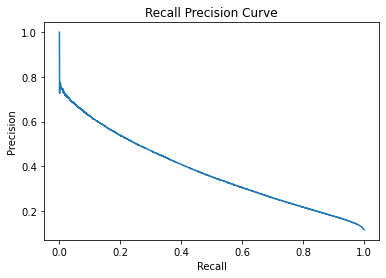

RecallPrecisionAUC: 0.37868700607010775
AveragePrecision: 0.3786909968253755


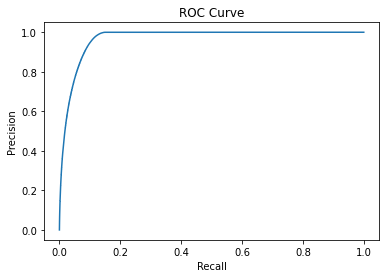

ROC_AUC: 0.969243314358323


In [16]:
 # Model Evaluation
model.eval()
val_loss = 0
val_batch_cnt = 0
TP, TN, FP, FN = 0, 0, 0, 0
scores = []
y = []
for seq_batch, _, label_batch in test_dataloader:
    seqs = []
    labels = []
    for i, seq in enumerate(seq_batch):
        seq = torch.tensor(seq).to(device)
        seq = seq.unsqueeze(dim=0)
        labels.append(label_batch[i])
        seqs.append(model(seq).squeeze())
    seqs = torch.cat(seqs)
    scores.append(torch.sigmoid(seqs).to('cpu').detach().numpy())
    labels = torch.cat(labels)
    y.append(labels.to('cpu').detach().numpy())
    labels = labels.to(device)
    val_loss += loss_fn(seqs, labels).item()
    seqs = seqs > 0
    labels = labels > .5
    TP += (seqs & labels).sum()
    FP += (seqs & ~labels).sum()
    TN += (~seqs & ~labels).sum()
    FN += (~seqs & labels).sum()
    val_batch_cnt += 1
val_loss /= val_batch_cnt
scores = np.concatenate(scores)
y = np.concatenate(y)

precision, recall, thresh = precision_recall_curve(y, scores)
rp_auc = auc(recall, precision)
fig = plt.figure()
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Recall Precision Curve')
#writer.add_figure('Test/RecallPrecisionCurve', fig, batch_num)
plt.show()
#writer.add_scalar('Test/RecallPrecisionAUC', rp_auc, batch_num)
print('RecallPrecisionAUC: ' + str(rp_auc))
ap = average_precision_score(y, scores)
#writer.add_scalar('Test/AveragePrecision', ap, batch_num)
print('AveragePrecision: ' + str(ap))

fpr, tpr, roc_thresh = roc_curve(y, scores)
roc_auc = auc(fpr, tpr)
fig = plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('ROC Curve')
plt.show()
#writer.add_figure('Test/ROCCurve', fig, batch_num)
print('ROC_AUC: ' + str(roc_auc))
#writer.add_scalar('Test/ROCAUC', roc_auc, batch_num)

#writer.add_scalar('Test/Loss', val_loss, batch_num)
#writer.add_scalar('Test/Accuracy', (TP+TN)/(TP+FP+TN+FN), batch_num)
#model.train()